In [1]:
import scipy, math
import matplotlib
import numpy as np
from matplotlib import pyplot as plt 
import pandas as pd
from tqdm.notebook import tqdm
from scipy.stats import norm
from scipy.optimize import minimize

import scipy.io
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

plt.style.use("ggplot")
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.style.use("default")
colors = colors[0:2] + colors[4:]

plt.rcParams.update({
    'font.size': 16,
    'figure.dpi':100,
    'figure.frameon': False,
    'axes.grid': False,
    'axes.spines.right' : False,
    'axes.spines.top' : False
})


In [2]:
# BPDS Functions
def a_j_calc(J, tau, x):
    a_s = np.zeros(J)
    for j in range(J):
        v = calc_v(vs[j], j, x)
        a_s[j] = np.sqrt((2*np.pi/tau))*norm.pdf(y0, ks[j]+bs[j]*x, np.sqrt((1+tau*v)/tau))*np.exp(-.5*tau*cs[j]*(x_hats[j] - x0)**2)
    return(a_s)

def a_j_deriv_calc(J, taus, x, a_s,  m_star, v_star):
    a_deriv = np.zeros(J)
    for j in range(J):
        a_deriv[j] = -a_s[j]/2*((m_star[j]-y0)**2+v_star[j]+cs[j]*(x_hats[j] - x0)**2)
    return(a_deriv) 


def a_j_deriv2_calc(J, taus, x, a_s,  m_star, v_star):
    a_deriv2 = np.zeros(J)
    for j in range(J):
        r = 2*((m_star[j]-y0)**2+v_star[j])*cs[j]*(x_hats[j] - x0)**2
        w = (((m_star[j]-y0)**4)+v_star[j]*6*((m_star[j]-y0)**2)+3*(v_star[j]**2))
        d = (cs[j]**2)*(x_hats[j] - x0)**4
        a_deriv2[j] = a_s[j]/4*(w+r+d)
    return(a_deriv2)

def g(tau, x, s, pis):
    #used to solve for tau corresponding to given s --> want g = 0
    J = len(pis)
    
    m_star = np.zeros((J,1))
    v_star = np.zeros((J,1))
    for j in range(J):
        v = calc_v(vs[j], j, x)
        m_star[j] = 1/(1+tau*v)*(ks[j]+bs[j]*x + tau*v*y0)
        v_star[j] = v/(1+tau*v)
    
    a_s = a_j_calc(J, tau, x)
    a_deriv = a_j_deriv_calc(J, tau, x, a_s, m_star, v_star)
    
    g = s - 1/(pis@a_s)*pis@a_deriv    
    return(g)

def g_scipy(taus, x, s, pis):
    
    return(np.abs(g(taus, x, s, pis)))

def G(tau, x, s, pis):
    #derivative of g
    J = len(pis)
    
    m_star = np.zeros((J,1))
    v_star = np.zeros((J,1))
    for j in range(J):
        v = calc_v(vs[j], j, x)
        m_star[j] = (ks[j]+bs[j]*x + tau*v*y0)/(1+tau*v)
        v_star[j] = v/(1+tau*v)
    
    a_s = a_j_calc(J, tau, x)
    a_deriv = a_j_deriv_calc(J, tau, x, a_s, m_star, v_star)
    a_deriv2 = a_j_deriv2_calc(J, tau, x, a_s,  m_star, v_star)
    G = 0 
    for j in range(J):
        G+= pis[j]*(s*a_deriv[j] - a_deriv2[j])
    
    return(1e4*G)

def G_scipy(tau, x, s, pis):
    g_ = g(tau, x, s, pis)
    G_ = G(tau, x, s, pis)
    return(g_/abs(g_) * G_)
    
def U(tau, x, pis):
    #given tau, x, and prior probabilities pis, calulcates BPDS loss and updated probabilities
    J = len(pis)

    m_star = np.zeros(J)
    v_star = np.zeros(J)
    a_s = a_j_calc(J, tau, x)
    k = 1/(pis@a_s)
    pi_tilde = np.zeros(J)
    u = 0
    for j in range(J):
        v = calc_v(vs[j], j, x)
        m_star[j] = (ks[j]+bs[j]*x + tau*v*y0)/(1+tau*v)
        v_star[j] = v/(1+tau*v)
        pi_tilde[j] = pis[j]*a_s[j]*k
    
    a_deriv = a_j_deriv_calc(J, tau, x, a_s, m_star, v_star)
    c = pi_tilde@cs
    v = pi_tilde@v_star + pi_tilde@(m_star**2) -  (pi_tilde@m_star)**2
    u = ((pi_tilde@m_star - y0)**2 +v + c*(x-x0)**2)
       
    return(u, pi_tilde, pi_tilde@m_star, v)   



In [3]:
def y_calc(x, other_x = [None, None]):
    if other_x[0] == None:
        x= x.reshape((-1, 3))
        return(.7 + 1.2*x[:,0] -  .9*x[:,1] )
    else:
        return(.7 +1.2*x - .9*other_x[0])

First we randomly generate some 3-dimensional data, then calculate our ys using $y = .7 + 1.2x_1 - .9x_2$

In [4]:
np.random.seed(12)
x_dat = np.random.uniform(low=0, high=2, size=(10,3))
y_dat = y_calc(x_dat)+ norm(loc=0, scale = .3).rvs(len(x_dat))

For our models, we use a variable selection set up- one model with only $x_1$, the next with $x_1, x_2$, and the last with $x_1, x_2, x_3$.

We assume known variance $v_j = .3^2$, and set priors $\beta_{j, 0} \sim N(0, c s_y)$ and $\beta_{j, i} \sim N(0, c \frac{s_y}{s_{x_i}})$ for $i=1,2, 3$, as priors on the coefficients, with $\beta_{1,2} = \beta_{1,3} = \beta_{2,3} = 0$ and $c=3$.

In [5]:
sigma2 = .3**2

In [6]:
def calc_params(X, y_dat):
    b0 = np.zeros(X.shape[1])
    var = np.ones(X.shape[1])*y_dat.var()*(3)**2
    var[1:] = var[1:]/X.var(axis=0)[1:]
    B = np.eye(len(var))*var
    
    
    lam0 = np.linalg.inv(B) 
    lam = 1/sigma2*X.T@X + lam0
    
    mu = 1/sigma2*X.T@y_dat + lam0@b0
    b = np.linalg.inv(lam)@mu

    l = scipy.stats.multivariate_normal(X@b0, X@B@X.T + sigma2*np.eye(len(y_dat))).pdf(y_dat)
    tmp = np.linalg.inv(X.T@X/sigma2 + np.linalg.inv(B))
    Sig = np.zeros((4,4))
    Sig[:len(tmp), :len(tmp)] = tmp
    return(l, b, Sig)


In [7]:
def calc_v(v, j, x):
    new_x = np.array([1, 1.1, .1, x])
    return(v + (new_x.T@Sigs[j]@new_x))

In [8]:
import statsmodels.api as sm
probs = np.zeros(3)
X = sm.add_constant(x_dat)
Sigs = np.zeros((4, 4, 4))
probs[0], m1_params, Sigs[0] = calc_params(X[:, :2], y_dat)
probs[1], m2_params, Sigs[1] = calc_params(X[:, :3], y_dat)
probs[2], m3_params, Sigs[2] = calc_params(X, y_dat)
params = np.array([[*m1_params,0,0], [*m2_params,0], [*m3_params]])

In [9]:
pis_bma = probs/sum(probs)

In [10]:
pis_bma.round(2)

array([0.  , 0.95, 0.05])

Fix the current values of $x_2, x_3$.

In [11]:
other_x = np.zeros(2)
other_x[0] = 1.1
other_x[1] = .1

Calculate model-optimal points + baseline model equally weighting each of the other models.

In [12]:
c = 1

In [13]:
ks = np.array([m1_params[0], m2_params[0]+m2_params[2]*other_x[0], m3_params[0] + m3_params[2:]@other_x.T])
J = len(ks)
bs = np.array([m1_params[1], m2_params[1], m3_params[1]])
cs = c*np.array([(bs[j]**2) for j in range(J)])
vs = np.array( [.3**2, .3**2, .3**2])
v = .3**2
x0 = 1
y0 = 1

pis = np.ones(J)/J

for i in range(3):
    Sigs[-1] += pis[i]*(Sigs[i] + params[i].reshape(-1, 1)@params[i].reshape(1, -1))
Sigs[-1] -= (pis@params).reshape(-1,1)@(pis@params).reshape(1,-1)
Sigs[-1] = 1/.135*Sigs[-1]

bs = np.append(bs, pis@bs)
ks = np.append(ks,  pis@ks)
vs = np.append(vs, 1/.135 * v)


J +=1
pis = np.ones(J)/J
                    
cs = c*np.array([(bs[j]**2) for j in range(J)])


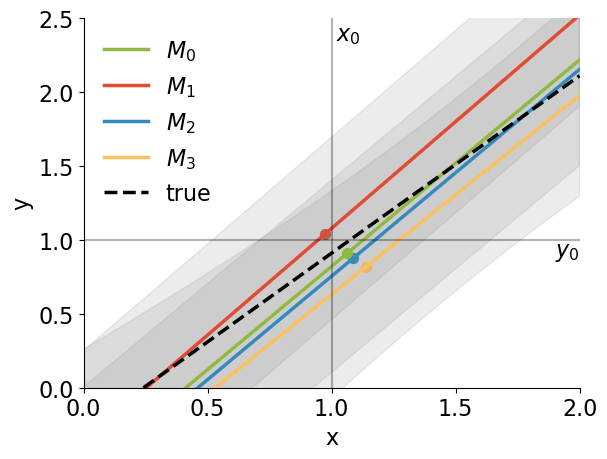

In [14]:
x_hats = np.zeros(J)


for j in range(J):
    x_hats[j] = (cs[j]*x0 + bs[j]*y0 - bs[j]*ks[j])/(cs[j]+bs[j]**2)


x_ax = np.linspace(0, 2, 10000)
plt.ylim((0, 2.5))
plt.xlim((0, 2))


for j in range(J):
    plt.plot(x_ax, ks[j] + bs[j]*x_ax, color=colors[j], label = 0, lw = 2.5)
plt.plot(x_ax,y_calc(x_ax, other_x), color="black", linestyle="--", label = 0, lw = 2.5)
    

    

handles, labels = plt.gca().get_legend_handles_labels()

labels = [r"$M_{}$".format(j+1) for j in range(J-1)]+ [r"$M_0$", "true"]
order = [3, 0, 1, 2, 4]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)

for j in range(J):
    plt.scatter(x_hats[j], ks[j] + bs[j]*x_hats[j],color=colors[j], s = 50)
    sd = np.sqrt(np.array([calc_v(vs[j], j, x_ax[i]) for i in range(len(x_ax))]))
    if j != J-1:plt.fill_between(x_ax, ks[j] + bs[j]*x_ax- 1.96*sd,  ks[j] + bs[j]*x_ax+1.96*sd, alpha=.15, color="gray")

plt.hlines(1, 0, 2.5, color="black", alpha=.3)
plt.vlines(1, 0, 4, color="black", alpha=.3)
plt.text(1.02, 2.35, r'$x_0$')
plt.text(1.9, .89, r'$y_0$')
plt.grid(False)
plt.ylabel("y")
plt.xlabel("x")
plt.savefig("ED_models.png")
plt.show()
#turn off box, grid, box around legend, rotate y axis label, make x_0, y_0 faint lines

Next we run the BPDS algorithm across a grid of $x$, calculating the optimal $\tau$ at each point $x$ for a desired expected score $s = \max_{j=1:J} E(s_j(\hat{x}_j,y))$. We use this to calculate the BPDS loss $L(x) = \tau(x)E[(y-y_0)^2 + c_j(x-x_0)^2]$.

In [15]:
x = np.linspace(.75, 1.25, 1000)
tau_store = np.zeros((1000, 1))
L_store = np.zeros((1000, 1))
g_store = np.zeros((1000, 1))
diff_store = np.zeros((1000, 3))

g_store = np.zeros((1000, 1))
s = -.5*(cs*(x_hats-x0)**2 +np.array([(ks + bs*x_hats-y0)**2]) +vs).min()
tau =  np.array([1])
pi_store = np.zeros([1000, J])
ms = np.zeros(1000)
v_store = np.zeros(1000)

bound = np.inf
for i in tqdm(range(len(x))):
    tau = scipy.optimize.minimize(g_scipy, jac = G_scipy, args = (x[i], s , pis), x0=tau,  bounds=np.array([(.00000001, bound)])
                                   )['x']
    tau2 = scipy.optimize.least_squares(g, x0= np.array([1]), args=(x[i], s, pis),  bounds=(.00000001, bound))['x']
    if g_scipy(tau2, x[i], s, pis) < g_scipy(tau, x[i], s, pis):
        tau=tau2
    g_store[i] = g(tau, x[i], s, pis)
    tau_store[i] = tau
    u, pi_tilde, m, v = U(tau, x[i], pis)
    ms[i] = m
    v_store[i] = v
    L_store[i] = u*tau
    pi_store[i] = pi_tilde
        
    


  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
#Equal mixture optimal point
num = 0
denom = 0
for j in range(J-1):
    num+= 1/3*(cs[j]*x0 + bs[j]*y0 - bs[j]*ks[j])
    denom += 1/3*(cs[j]+bs[j]**2)
x_eq= num/denom
y_eq = y_calc(x_eq, other_x)
print("Equal Optimal x:",np.round(x_eq,3))

Equal Optimal x: 1.062


In [17]:
denom = 0
num = 0
for j in range(J-1):
    #x_hats[j] = (cs[j]*x0 + bs[j]*y0 - bs[j]*ks[j])/(cs[j]+bs[j]**2)
    num+=pis_bma[j]*(cs[j]*x0 + bs[j]*y0 - bs[j]*ks[j])
    denom += pis_bma[j]*(cs[j]+bs[j]**2)
x_bma = num/denom
y_bma = y_calc(x_bma, other_x)
print("BMA Optimal x:",np.round(x_bma,3))

BMA Optimal x: 1.09


In [18]:
#BPDS optimal

x_bpds =x[L_store.argmin()]
print("Optimal x:",np.round(x_bpds,3))
pi_tilde = pi_store[L_store.argmin()]
print('pi tilde at opt x:',np.round(pi_tilde,3))

y_bma = y_calc(x_bma, other_x)
y_bpds = y_calc(x_bpds, other_x)


Optimal x: 1.023
pi tilde at opt x: [0.34  0.294 0.232 0.134]


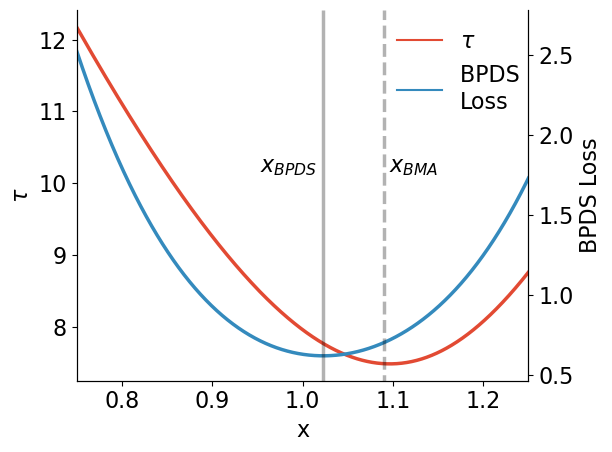

In [19]:
from matplotlib.lines import Line2D

fig, ax1 = plt.subplots()
ax1.set_xlabel('x')
ax1.set_ylabel(r"$\tau$")
ax1.plot(x, tau_store, color=colors[0], lw = 2.5)
ax1.set_xlim([.75, 1.25])
ax1.spines['right'].set_visible(True)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.spines['right'].set_visible(True)
ax2.set_ylabel('BPDS Loss')  # we already handled the x-label with ax1
ax2.plot(x, L_store, color=colors[1], lw = 2.5)

ax2.vlines(x_bpds,L_store.min()*.5, L_store.max()*1.1, color="k", alpha=.3, lw = 2.5)
ax2.text(x_bpds-.07, L_store.max()*.7, r'$x_{BPDS}$')

ax2.vlines(x_bma, L_store.min()*.5, L_store.max()*1.1, color="k", alpha=.3, linestyle = "--", lw = 2.5)
ax2.text(x_bma+.005, L_store.max()*.7, r'$x_{BMA}$')

ax2.set_ylim([L_store.min()*.75, L_store.max()*1.1])
fig.tight_layout()  # otherwise the right y-label is slightly clipped

ax1.grid(False)
ax2.grid(False)

handles, labels = plt.gca().get_legend_handles_labels()

lines = [Line2D([0], [0], label=r'$\tau$', color=colors[0]),
        Line2D([0], [0], label='BPDS \nLoss', color=colors[1])]

handles.extend(lines)

plt.legend(handles=handles, frameon=False, loc = "upper right", bbox_to_anchor = (1.04,1))
plt.savefig("ED_tau_util.png")

plt.show()


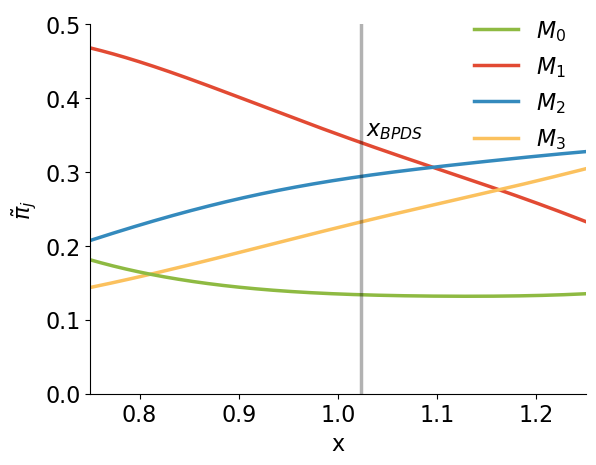

In [20]:
for i in range(len(pi_store.T)):
    plt.plot(x, pi_store[:,i], color = colors[i], label = 0, lw = 2.5)



plt.xlim([.75,1.25])
handles, labels = plt.gca().get_legend_handles_labels()

labels = [r"$M_{}$".format(j+1) for j in range(J-1)]+ [r"$M_0$"]
order = [3, 0, 1, 2]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False, 
           loc="upper right", bbox_to_anchor = (1,1.07))
plt.ylabel(r'$\tilde{\pi}_j$')
plt.xlabel("x")
plt.vlines(x[L_store.argmin()],0,1.1, color="k", alpha=.3, lw = 2.5)
plt.ylim((0,.5))
plt.text(x[L_store.argmin()]+.005, .35, r'$x_{BPDS}$')
plt.grid(False)
plt.savefig("ED_pi_tilde.png")

plt.show()

In [21]:
c = 1.2**2
table = pd.DataFrame({"model" : [r"$\cM_{}$".format(i) for i in range(1,4)] + [r"$\cM_0$"]+["Equal", "BMA", "BPDS"],
                      "opt_x": list(x_hats)+[x_eq, x_bma, x_bpds],
                      "y": list(y_calc(x_hats, other_x))+[y_eq, y_bma, y_bpds],
              "Loss" : list((y_calc(x_hats, other_x) - y0)**2+c*(x0-x_hats)**2) +
            [(y_eq - 1)**2 +c*(x_eq-x0)**2, (y_bma - 1)**2 +c*(x_bma-x0)**2,
             (y_bpds- 1)**2 +c*(x_bpds-x0)**2]})
table["Loss"]= 100*table["Loss"]
table["Loss %"] = (100*(table["Loss"]/table.loc[table.index[-1], "Loss"] - 1)).astype(int)
print(table.to_latex(column_format="lccc", float_format="%.2f", index = False, escape = False))

\begin{tabular}{lccc}
\toprule
  model &  opt_x &    y &  Loss &  Loss % \\
\midrule
$\cM_1$ &   0.97 & 0.88 &  1.60 &     242 \\
$\cM_2$ &   1.09 & 1.02 &  1.14 &     143 \\
$\cM_3$ &   1.14 & 1.07 &  3.26 &     598 \\
$\cM_0$ &   1.06 & 0.99 &  0.61 &      30 \\
  Equal &   1.06 & 0.98 &  0.58 &      24 \\
    BMA &   1.09 & 1.02 &  1.21 &     158 \\
   BPDS &   1.02 & 0.94 &  0.47 &       0 \\
\bottomrule
\end{tabular}



/var/folders/zx/ll75g08101sd_13rlmzl1q2h0000gn/T/ipykernel_53883/4031355805.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(column_format="lccc", float_format="%.2f", index = False, escape = False))
